In [2]:
import gammapy
print(gammapy.__version__ , " == 1")

0.1.dev19174+g56b5bdf  == 1


In [3]:
import numpy as np
import os
import astropy
from astropy import units as u
import matplotlib.pyplot as plt

from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from collections import OrderedDict
from astropy import units
from gammapy.data import DataStore
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, DataStore, observatory_locations
from astropy.coordinates import SkyOffsetFrame
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.datasets import MapDataset
from gammapy.irf import load_cta_irfs, EDispKernel, PSFKernel
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion, RectangleSkyRegion


In [4]:
dataset_public = MapDataset.read('dataset-stacked.fits.gz')
empty = dataset_public.copy()

models  = Models.read('../standard_model.yml')

path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/crab/out'
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
observations = data_store.get_observations(data_store.obs_ids)


In [5]:
timeobs = []
for obs in observations:
    timeobs.append(obs.obs_info['TSTOP']-obs.obs_info['TSTART'])
timeobs = timeobs * u.s
print(timeobs.to(u.hr))
np.sum(timeobs)

[0.46861111 0.4675     0.46833333 0.46833333] h


<Quantity 6742. s>

In [6]:
angle = []
for obs in observations:
    angle.append(90-obs.obs_info['ALT_PNT'])
np.mean(angle), np.std(angle)

(47.036731566875076, 1.472275046346821)

In [7]:
n_public_runs = len(observations)
location = observatory_locations['hess']

livetime_stereo = 50.089999999999996 *u.hr
livetime_mono = 29.94 * u.hr
livetime_simu = 100 * u.hr # livetime_stereo + livetime_mono
livetime_public =np.sum(timeobs).to(u.hr)
print('public:', livetime_public)
print('simu:', livetime_simu)
factors =( (livetime_simu/n_public_runs) / timeobs ).to("")
print("factors", factors)

public: 1.8727777777777779 h
simu: 100.0 h
factors [53.34914049 53.47593583 53.38078292 53.38078292]


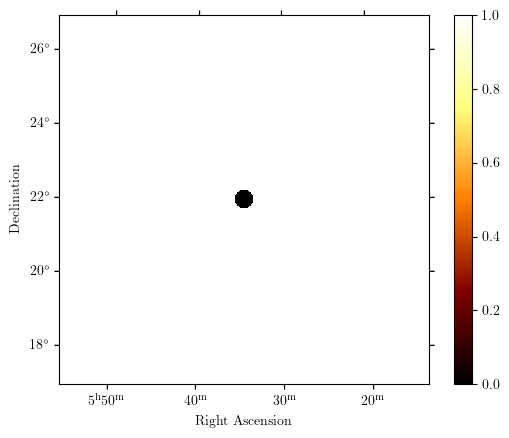

In [8]:
crab_pos = SkyCoord("83.63", "22.01",  unit='deg', frame='icrs')

radius = 0.25*u.deg
skyregion = CircleSkyRegion(center=crab_pos, radius=radius)
excl_regions = [skyregion]
geom = dataset_public.geoms['geom']
excl_mask_2d = Map.from_geom(dataset_public.geoms['geom'].to_image(),
                             data=dataset_public.geoms['geom'].to_image().region_mask(excl_regions, inside=False).data)
excl_mask_2d.plot(add_cbar = 1, vmin =0, vmax = 1);

maxthreshold  = 1*u.TeV
ebins = np.logspace(-1,2,25) *u.TeV
max_offset = 2 *u.deg

In [9]:
datasets = []
for i in range(n_public_runs):
    print(i)
    dataset_obs = MapDataset.read(f'dataset-obs-{observations[i].obs_id}.fits.gz')
    irfs = {'bkg':dataset_obs.background,
       'aeff': dataset_obs.exposure * factors[i],#/ livetime ,
       'psf': dataset_obs.psf,
       'edisp': dataset_obs.edisp,
       'rad_max': 4 *u.deg }
    
    pointing  = observations[i].pointing_radec

    obs = Observation.create(
        pointing=pointing, livetime=timeobs[i], irfs=irfs, location=location
    )
    
    # Make the MapDataset
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
    reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)    

    dataset = maker.run(reference, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    
    dataset.counts.data = dataset.counts.data.astype(np.float32)
    dataset.psf = dataset_obs.psf
    dataset.edisp = dataset_obs.edisp
    
    datasets.append(dataset)
    

0


/tmp/ipykernel_1601708/275736454.py:11: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1601708/275736454.py:21: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

1


/tmp/ipykernel_1601708/275736454.py:11: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1601708/275736454.py:21: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

2


/tmp/ipykernel_1601708/275736454.py:11: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1601708/275736454.py:21: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

3


/tmp/ipykernel_1601708/275736454.py:11: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1601708/275736454.py:21: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

In [10]:
dataset_stacked = datasets[0].copy()
dataset_stacked.stack(datasets[1])
dataset_stacked.stack(datasets[2])
dataset_stacked.stack(datasets[3])



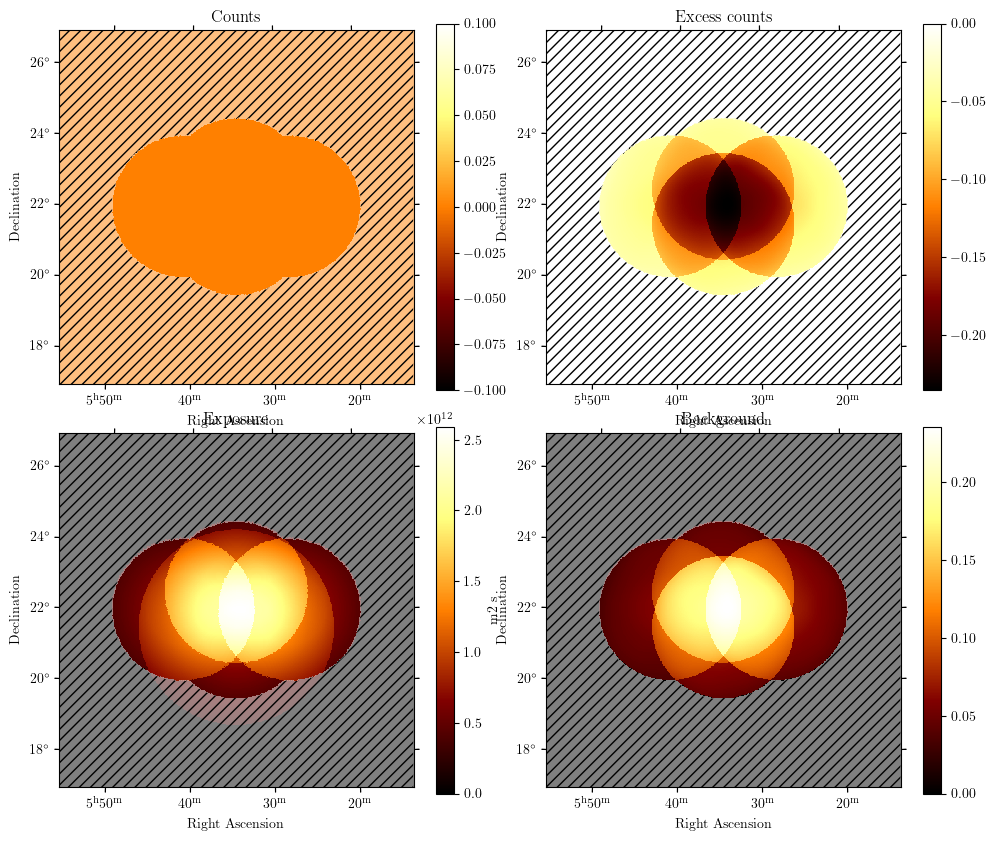

In [11]:
dataset_stacked.peek()

## Creating the models

In [12]:
import operator
from gammapy.modeling.models import (
    PointSpatialModel,
    PowerLawSpectralModel, 
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    GaussianSpectralModel,
    CompoundSpectralModel,
    SkyModel
)

In [16]:
spatial_model = PointSpatialModel(lon_0 = crab_pos.ra, 
                                  lat_0 = crab_pos.dec,
                                  frame= 'icrs')

crab_par = dict()
# https://arxiv.org/pdf/1509.02902.pdf
a = {'value':1.79e-10, 'error':0.03e-10}
crab_par['amplitude'] = a
alpha = {'value':2.10, 'error':0.04}
crab_par['alpha'] = alpha
beta = {'value':0.24, 'error':0.01}
crab_par['beta'] = beta
reference = {'value':0.521, 'error':0.0}
crab_par['reference'] = reference
logparabola_model = LogParabolaSpectralModel()
for par in logparabola_model.parameters:
    par.value = crab_par[par.name]['value']
    par.error = crab_par[par.name]['error']

crab_reference = 1 *u.TeV
crab_index = 2.9
crab_amplitude = logparabola_model(crab_reference)
print(crab_amplitude)
powerlaw_model = PowerLawSpectralModel(
    amplitude =crab_amplitude, 
    index = crab_index,
    reference = crab_reference)
crab_lambda = 1/ (30 * u.TeV)
expcutpowerlaw_model = ExpCutoffPowerLawSpectralModel(
    amplitude = crab_amplitude, 
    index = crab_index,
    reference = crab_reference,
    lambda_ = crab_lambda)
crab_mean = 20*u.TeV
crab_sigma = 0.5 *u.TeV
gaussian_model = GaussianSpectralModel(mean  = crab_mean,
                                      sigma = crab_sigma)
gaussian_model = CompoundSpectralModel(model1 = expcutpowerlaw_model, 
                                      model2 = gaussian_model,
                                      operator = operator.add)

powerlaw = SkyModel(spatial_model = spatial_model,
                    spectral_model = powerlaw_model,
                    name = "PL")

expcutpowerlaw = SkyModel(spatial_model = spatial_model,
                    spectral_model = expcutpowerlaw_model,
                    name = "ECPL")

gaussian = SkyModel(spatial_model = spatial_model,
                    spectral_model = gaussian_model,
                    name = "GPL")

logparabola = SkyModel(spatial_model = spatial_model,
                       spectral_model = logparabola_model,
                    name = "LP")
gaussian.parameters['amplitude_'].frozen = True
gaussian.parameters['lambda_'].frozen = True
Models([logparabola]).write("model-lp.yaml", overwrite = True)


4.110575798345751e-11 1 / (cm2 s TeV)


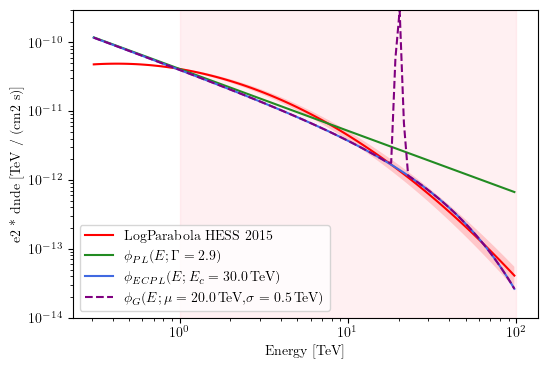

In [42]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
colors = ['red', 'forestgreen', 'royalblue','purple']


energy_bounds = [0.3, 100] *u. TeV
energy_power = 2
logparabola_model.plot(energy_bounds,label = "LogParabola HESS 2015",
                      energy_power = energy_power,
                      color = colors[0])
logparabola_model.plot_error(energy_bounds, energy_power = energy_power,
                             facecolor = colors[0])

powerlaw_model.plot(energy_bounds,
                    label = "$\phi_{PL}$"+f"$(E; \Gamma = {crab_index}$)",
                   energy_power = energy_power, 
                    color = colors[1])

expcutpowerlaw_model.plot(energy_bounds, 
                        label = "$\phi_{ECPL}$"+f"$(E; E_c = {1/crab_lambda.value}\,$TeV)",
                         energy_power = energy_power,
                          color = colors[2])

gaussian_model.plot(energy_bounds, 
                    label = f"$\phi_G(E; \mu = {crab_mean.value}\,$TeV,$ \sigma = {crab_sigma.value}\,$TeV)",
                   energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = colors [3])


plt.legend()

plt.ylim(1e-14, 3e-10)
plt.fill_betweenx(ax.get_ylim(), 1,100, color = 'lightpink', alpha = 0.2)

fig.savefig("plots/2_input_spectra.pdf")

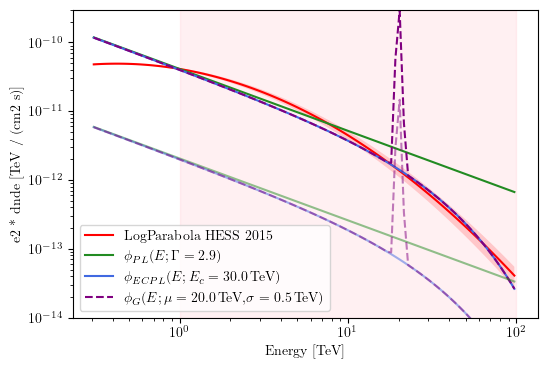

In [43]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
colors = ['red', 'forestgreen', 'royalblue','purple']


energy_bounds = [0.3, 100] *u. TeV
energy_power = 2
logparabola_model.plot(energy_bounds,label = "LogParabola HESS 2015",
                      energy_power = energy_power,
                      color = colors[0])
logparabola_model.plot_error(energy_bounds, energy_power = energy_power,
                             facecolor = colors[0])

powerlaw_model.plot(energy_bounds,
                    label = "$\phi_{PL}$"+f"$(E; \Gamma = {crab_index}$)",
                   energy_power = energy_power, 
                    color = colors[1])

expcutpowerlaw_model.plot(energy_bounds, 
                        label = "$\phi_{ECPL}$"+f"$(E; E_c = {1/crab_lambda.value}\,$TeV)",
                         energy_power = energy_power,
                          color = colors[2])

gaussian_model.plot(energy_bounds, 
                    label = f"$\phi_G(E; \mu = {crab_mean.value}\,$TeV,$ \sigma = {crab_sigma.value}\,$TeV)",
                   energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = colors [3])


models  = [powerlaw_model,expcutpowerlaw_model,gaussian_model]
for m in models:
    m.parameters['amplitude'].value = 0.05 * crab_amplitude.value
    if 'amplitude_' in m.parameters.names:
        m.parameters['amplitude_'].value = 0.05 *  1.0000e-12

powerlaw_model.plot(energy_bounds,
                    label = "",
                   energy_power = energy_power, 
                    color = colors[1],
                   alpha = 0.5)

expcutpowerlaw_model.plot(energy_bounds, 
                        label = "",
                         energy_power = energy_power,
                          color = colors[2],
                         alpha = 0.5)

gaussian_model.plot(energy_bounds, 
                    label = f"",
                    energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = colors [3],
                   alpha = 0.5)
for m in models:
    m.parameters['amplitude'].value =  crab_amplitude.value
    if 'amplitude_' in m.parameters.names:
        m.parameters['amplitude_'].value =  1.0000e-12
plt.legend()

plt.ylim(1e-14, 3e-10)
plt.fill_betweenx(ax.get_ylim(), 1,100, color = 'lightpink', alpha = 0.2)

fig.savefig("plots/2_input_spectra_weak.pdf")

In [44]:
dataset_pl = dataset_stacked.copy()
dataset_pl.models = powerlaw.copy()
dataset_ecpl = dataset_stacked.copy()
dataset_ecpl.models = expcutpowerlaw.copy()
dataset_plg = dataset_stacked.copy()
dataset_plg.models = gaussian.copy()


dataset_pl.counts = dataset_pl.npred()
dataset_ecpl.counts = dataset_ecpl.npred()
dataset_plg.counts = dataset_plg.npred()

#dataset_pl.fake(28)
#dataset_ecpl.fake(18)
#dataset_plg.fake(8)



update evaluator
update evaluator
update evaluator


In [45]:
dataset_pl.write("dataset-simulated-pl.fits.gz", overwrite = True)
dataset_pl.models.write("model-pl.yaml", overwrite = True)
dataset_ecpl.write("dataset-simulated-ecpl.fits.gz", overwrite = True)
dataset_ecpl.models.write("model-ecpl.yaml", overwrite = True)
dataset_plg.write("dataset-simulated-plg.fits.gz", overwrite = True)
dataset_plg.models.write("model-plg.yaml", overwrite = True)

In [46]:
%%time

fit = Fit()
fit.run([dataset_pl])
fit.run([dataset_ecpl])
fit.run([dataset_plg])

update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
CPU times: user 35.6 s, sys: 2.14 s, total: 37.8 s
Wall time: 37.9 s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization failed.
	nfev       : 98
	total stat : 18557.49

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1137: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


(<WCSAxes: >,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals ((data - model) / sqrt(model))'>)

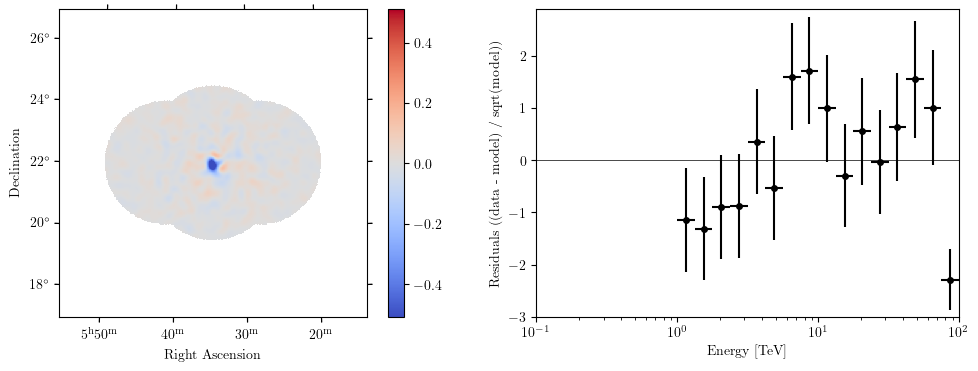

In [27]:
dataset_pl.plot_residuals(kwargs_spatial={'vmax':0.51,
                                      'vmin':-0.51},
                      kwargs_spectral={'method' : 'diff/sqrt(model)'})

In [17]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m[0].parameters[p[0]],
                 m[model_name].parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                        fmt = fmts[j],
                        markersize = markersize[j])
            except:
                pass

    plt.tight_layout()

labels = ['simulated', 'recovered pl', 'recovered ecpl']
fmts = ['o','x']
markersize = [6,10]

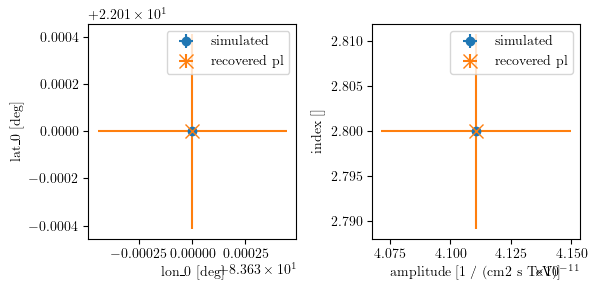

In [18]:
models_list = [Models(powerlaw), dataset_pl.models, ]

pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'),]
plot_source_par(0, pars)


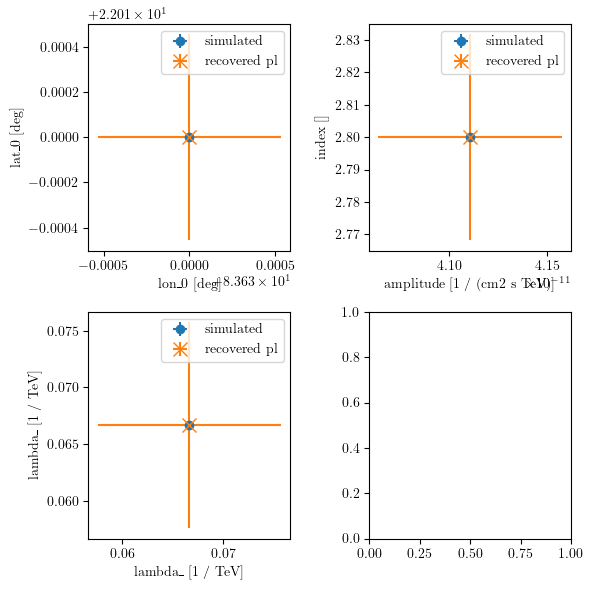

In [19]:
models_list = [Models(expcutpowerlaw), dataset_ecpl.models, ]
pars= [('lon_0', 'lat_0'),('amplitude', 'index'),
                ('lambda_', 'lambda_')]

plot_source_par(0, pars)


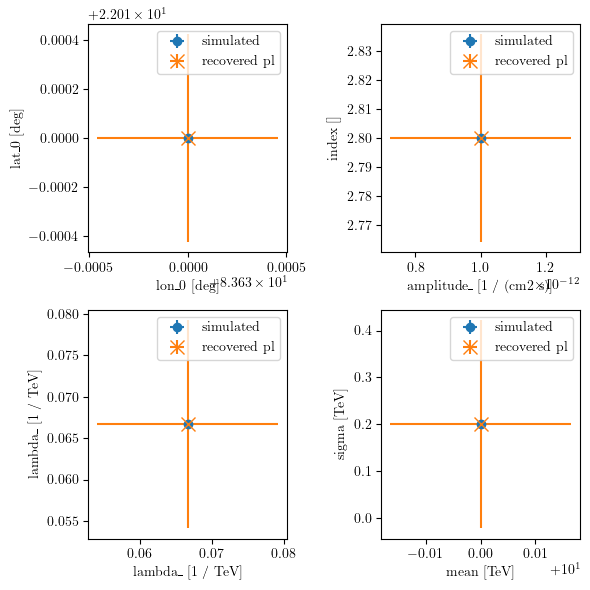

In [20]:
models_list = [Models(gaussian), dataset_plg.models, ]
pars= [('lon_0', 'lat_0'),('amplitude_', 'index'),
                ('lambda_', 'lambda_'), ('mean', 'sigma')]

plot_source_par(0, pars)


[]

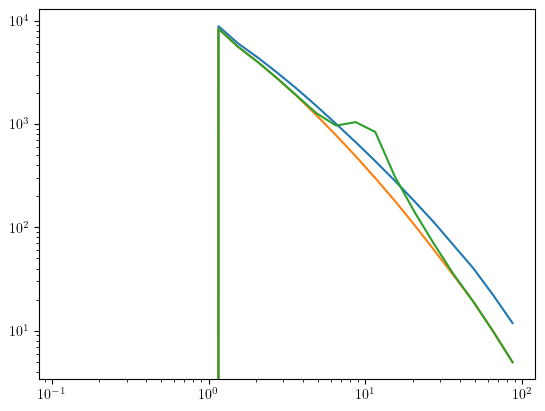

In [21]:
ee = dataset_pl.geoms['geom'].axes[0].center.value
labels = ['PL', 'ECPL', 'G']
datasets = [dataset_pl, dataset_ecpl, dataset_plg]
for i, d in enumerate(datasets):
    plt.plot(ee, 
         (d.counts* d.mask).data.sum(axis=2).sum(axis=1),
            label = labels[i])
plt.loglog()

In [30]:
stat_sums = []
stat_sumsH0 = []

for d in datasets:
    stat_sums.append(d.stat_sum())

    with d.models.parameters.restore_status():
        d.models.parameters['amplitude'].value = 0
        try:
            d.models.parameters['amplitude_'].value = 0
        except:
            pass
        stat_sumsH0.append(d.stat_sum())
        
        
                     

In [31]:
print(stat_sums)
print(stat_sumsH0)
print(np.array(stat_sumsH0) - np.array(stat_sums))
print(np.sqrt(np.array(stat_sumsH0) - np.array(stat_sums)))

[10980.841578184103, 20224.89242162449, 19525.31945485424]
[219653.28583263085, 194264.22400559828, 210120.16291023474]
[208672.44425445 174039.33158397 190594.84345538]
[456.80679095 417.18021476 436.57169337]
